In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import itertools

from PIL import ImageFont
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.segmentation import mark_boundaries

import visualkeras
import lime
from lime import lime_image
from tf_keras_vis.activation_maximization import ActivationMaximization

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

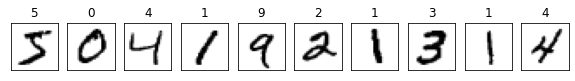

In [4]:
fig, ax = plt.subplots(1, 10, figsize=(10,10))
for i in range(0, 10):
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(y_train[i])
    ax[i].imshow(x_train[i], cmap=plt.cm.binary)

In [5]:
x_train = np.expand_dims(x_train, axis=-1).astype('float32')
x_test = np.expand_dims(x_test, axis=-1).astype('float32')

In [6]:
x_train /= 255
x_test /= 255

In [7]:
print('Data shape', x_train.shape)
print('Label shape', y_train.shape)
print('Number of training samples:', x_train.shape[0])
print('Number of testing samples:', x_test.shape[0])

Data shape (60000, 28, 28, 1)
Label shape (60000,)
Number of training samples: 60000
Number of testing samples: 10000


In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]
num_features = x_train.shape[1] + x_train.shape[2]

print('Number of classes: ', num_classes)

Number of classes:  10


In [9]:
model = load_model('model_mnist.hdf5')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          3

In [11]:
score = model.evaluate(x_test, y_test)
print("Test loss: ", score[0])
print("Test accuracy: ",score[1])

313/313 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9934
Test loss:  0.026308776810765266
Test accuracy:  0.993399977684021


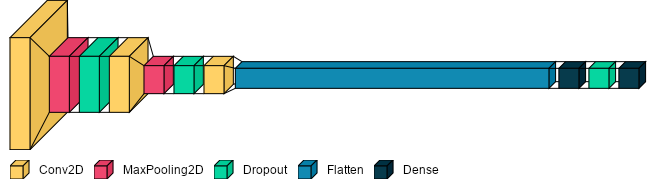

In [12]:
font = ImageFont.truetype("arial.ttf", 12)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!

Text(0.5, 37.5, 'Predicted label')

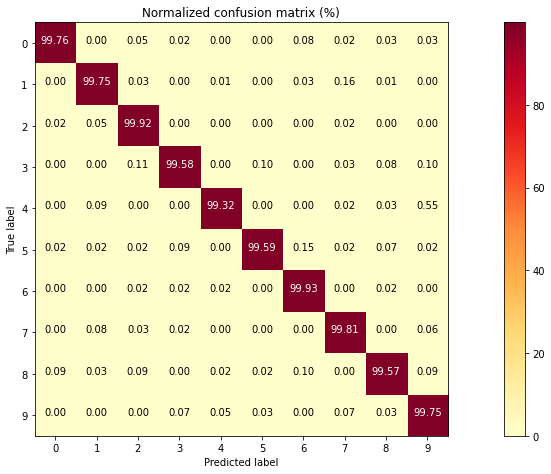

In [13]:
# Plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(16,6.5))
shrink=1
y_pred=model.predict(x_train)
y_actual=np.argmax(y_train, axis = -1)
y_pred=np.argmax(y_pred, axis = -1)
# Define confusion matrix
cm = confusion_matrix(y_actual,y_pred)
cm0 = cm
cm = 100*cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
n_classes = len((y_train[0]))

plt.sca(ax)
plt.imshow(cm, cmap = 'YlOrRd')
plt.title('Normalized confusion matrix (%)')
plt.colorbar(shrink=shrink)
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, np.arange(n_classes))
plt.yticks(tick_marks, np.arange(n_classes))
thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if i!=j:
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    if i==j:
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [14]:
layer_outputs = [layer.output for layer in model.layers[:]] 
for i in range(len(layer_outputs)):
    print('{} layer: {}'.format(i, layer_outputs[i]))
idx = [0, 3, 6]
layer_outputs2 = []
for temp in idx:
    layer_outputs2.append(layer_outputs[temp])

0 layer: Tensor("conv2d/Relu:0", shape=(None, 28, 28, 32), dtype=float32)
1 layer: Tensor("max_pooling2d/MaxPool:0", shape=(None, 14, 14, 32), dtype=float32)
2 layer: Tensor("dropout/cond/Identity:0", shape=(None, 14, 14, 32), dtype=float32)
3 layer: Tensor("conv2d_1/Relu:0", shape=(None, 14, 14, 64), dtype=float32)
4 layer: Tensor("max_pooling2d_1/MaxPool:0", shape=(None, 7, 7, 64), dtype=float32)
5 layer: Tensor("dropout_1/cond/Identity:0", shape=(None, 7, 7, 64), dtype=float32)
6 layer: Tensor("conv2d_2/Relu:0", shape=(None, 7, 7, 64), dtype=float32)
7 layer: Tensor("flatten/Reshape:0", shape=(None, 3136), dtype=float32)
8 layer: Tensor("dense/Relu:0", shape=(None, 128), dtype=float32)
9 layer: Tensor("dropout_2/cond/Identity:0", shape=(None, 128), dtype=float32)
10 layer: Tensor("dense_1/Softmax:0", shape=(None, 10), dtype=float32)


In [15]:
activation_model = Model(inputs=model.input, outputs=layer_outputs2)

In [16]:
activations = activation_model.predict(x_test[:1])

<ipython-input-17-1c3a489474f7>:14: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


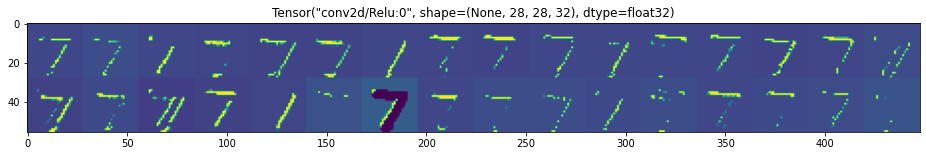

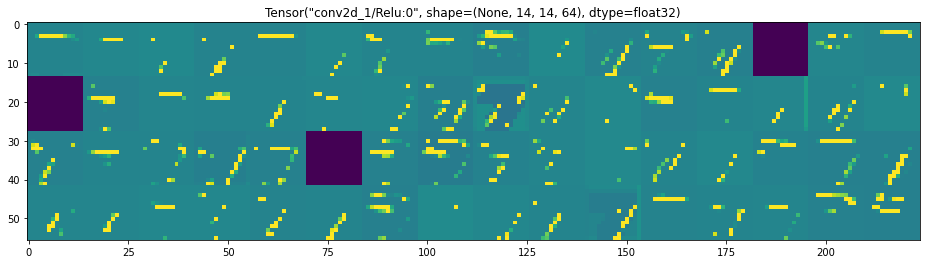

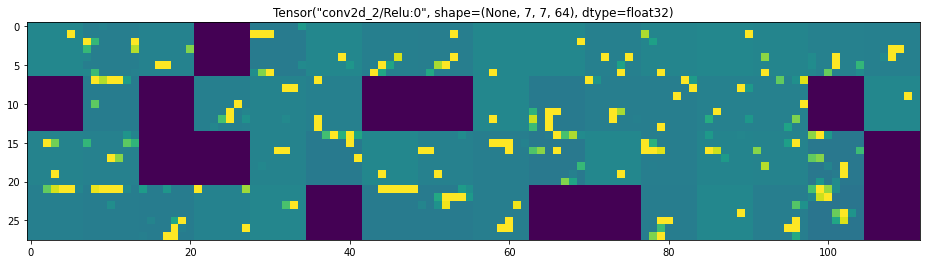

In [17]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_outputs2, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            #print(layer_activation.shape)
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(str(layer_name))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [19]:
layer_name = 'dense_1' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

In [20]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

In [107]:
def loss(output):
    return output[..., filter_number]

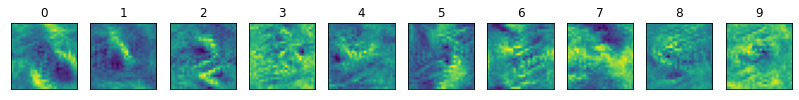

In [109]:
fig, ax = plt.subplots(1, 10, figsize=(14,14))
for i in range(0, 10):
    filter_number = i
    activation = activation_maximization(loss)
    image = activation[0].astype(np.uint8)
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(str(i))
    ax[i].imshow(image)

In [112]:
explainer = lime_image.LimeImageExplainer()

In [121]:
def new_predict_fn(images):
    return model.predict(images[:,:,:,:1])

In [134]:
explanation = explainer.explain_instance(np.squeeze(x_train[0].astype('double')), new_predict_fn, hide_color=0)

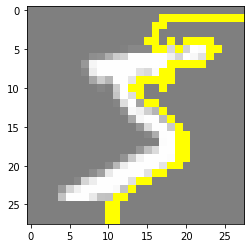

In [136]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))